# Market Neutral Long-Short Strategy using ML to Predict Short-Term Outperformance between Stocks
This project focuses on developing, evaluating and backtesting a market-neutral long-short strategy that leverages a machine learning model to predict the short-term outperformance between Expedia Group and Johnson and Johnson, two prominent stocks in the market. Expedia Group represents a cyclical stock, closely tied to economic cycles and consumer spending patterns, while Johnson and Johnson represents a non-cyclical stock, known for its stability and resilience during economic downturns.

By incorporating the cyclical and non-cyclical nature of these stocks into the ML model, the project aims to identify opportunities for higher returns by predicting which stock will outperform the other in the following 15 minutes, and taking a short position in the one that is predicted to have lower returns and a long position in the stock that is predicted to outperform. This approach takes advantage of the divergent characteristics of the stocks, allowing for potential gains in both bullish and bearish market conditions.

The following libraries will be used in this project and are imported here:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# dataset is in 15min interval so we have a variable to keep track of a trading day
day = int(4*6.5)

## 1) Importing and Preparing Data
We begin by importing the stock data from the past 10 years. Refer to the getdata.py file to see the script that generated the data that is being loaded. An Alpaca account is required to reproduce the data. 

In [2]:
jnj = pd.read_csv("./data/JNJ.csv", index_col=1, parse_dates=True).drop(['i', 'n', 'vw'], axis=1)
expe = pd.read_csv("./data/EXPE.csv", index_col=1, parse_dates=True).drop(['i', 'n', 'vw'], axis=1)


We then add a new column to each data frame, containing the percentage returns of the next 15 minutes. This determines which stock should be sold and which should be bought for that interval.

In [3]:
expe['future_returns'] = expe['Close'].pct_change().shift(-1)
jnj['future_returns'] = jnj['Close'].pct_change().shift(-1)

## 2) Feature Selection and Calculation

We will be considering the following feature variables to determine which stock will outperform the other the following 15 minutes:
1. Percentage changes from 1, 2 and 5 previous intervals.
2. Technical indicators including the following:
   1. Relative Strength Index (RSI): RSI is a momentum oscillator that measures the speed and change of price movements. It provides an indication of whether a stock is overbought or oversold, which can help predict potential reversals in price trends.
   2. Average Directional Index (ADX): ADX is a trend indicator that measures the strength of a stock's trend. It helps determine whether a stock is in a trending or ranging phase, which can be useful for predicting the continuation or reversal of trends.
   3. Moving Average Convergence Divergence (MACD): MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a stock's price. It helps identify potential buying and selling opportunities by indicating changes in the strength, direction, and duration of a trend.
   4. Bollinger Bands: Bollinger Bands consist of a set of lines plotted two standard deviations away from a stock's moving average. They provide a visual representation of a stock's volatility and can be useful for predicting potential price breakouts or reversals.
   5. Stochastic Oscillators: Stochastic Oscillators are momentum indicators that compare a stock's closing price to its price range over a certain period. They help identify overbought or oversold conditions, which can signal potential trend reversals.
   6. Commodity Channel Index (CCI): CCI is a versatile indicator that measures a stock's current price level relative to an average price over a specific period. It helps identify overbought or oversold conditions and potential trend reversals.
   7. On-Balance Volume (OBV): OBV is a volume-based indicator that measures buying and selling pressure. It takes into account the cumulative volume of a stock's trading and can provide insights into the strength of a price trend. Changes in OBV can help predict potential reversals or confirm the strength of a trend.
3. The closing price moving average of the past day, 5 days and the correlation between the closing price and the 1 day moving average.
4. The volatility int the past 1 day and 2 days. 

In [4]:
#Percentage returns

#Expedia Group
expe['pct_change'] = expe['Close'].pct_change(1)
expe['pct_change2'] = expe['Close'].pct_change(2)
expe['pct_change5'] = expe['Close'].pct_change(5)

#Booking
jnj['pct_change'] = jnj['Close'].pct_change(1)
jnj['pct_change2'] = jnj['Close'].pct_change(2)
jnj['pct_change5'] = jnj['Close'].pct_change(5)


#Technical indicators

#Expedia Group
expe['rsi'] = ta.RSI(expe['Close'].values, timeperiod = day)
expe['adx'] = ta.ADX(expe['High'].values, expe['Low'].values, expe['Open'].values, timeperiod = day)

#Booking
jnj['rsi'] = ta.RSI(jnj['Close'].values, timeperiod = day)
jnj['adx'] = ta.ADX(jnj['High'].values, jnj['Low'].values, jnj['Open'].values, timeperiod = day)


#Moving Averages

#Expedia Group
expe['sma1'] = expe['Close'].rolling(day).mean()
expe['sma5'] = expe['Close'].rolling(5*day).mean()
expe['corr'] = expe['Close'].rolling(day).corr(expe['sma1'])

#Booking
jnj['sma1'] = jnj['Close'].rolling(day).mean()
jnj['sma5'] = jnj['Close'].rolling(5*day).mean()
jnj['corr'] = jnj['Close'].rolling(day).corr(jnj['sma1'])


#Volatility

#Expedia Group
expe['vol1'] = expe['Close'].rolling(day).std()*100
expe['vol2'] = expe['Close'].rolling(2*day).std()*100


#Booking
jnj['vol1'] = jnj['Close'].rolling(day).std()*100
jnj['vol2'] = jnj['Close'].rolling(2*day).std()*100


#drop the missing values
expe.dropna(inplace = True)
jnj.dropna(inplace = True)

In [5]:
# Moving Average Convergence Divergence (MACD)

# Expedia Group
ema_12 = expe['Close'].ewm(span=12, adjust = False).mean()
ema_26 = expe['Close'].ewm(span=26, adjust = False).mean()
expe['MACD'] = ema_12-ema_26
expe['MACD_signal'] = expe['MACD'].ewm(span=9, adjust = False).mean()

# Booking
ema_12 = jnj['Close'].ewm(span=12, adjust = False).mean()
ema_26 = jnj['Close'].ewm(span=26, adjust = False).mean()
jnj['MACD'] = ema_12-ema_26
jnj['MACD_signal'] = jnj['MACD'].ewm(span=9, adjust = False).mean()



# Bollinger bands

std_multiplier = 2
# Expedia Group
rolling_mean = expe['Close'].rolling(20*day).mean()
rolling_std = expe['Close'].rolling(20*day).std()
expe['Bollinger_Lower'] = rolling_mean - rolling_std * std_multiplier
expe['Bollinger_Middle'] = rolling_mean
expe['Bollinger_Upper'] = rolling_mean + rolling_std * std_multiplier

# Booking
rolling_mean = jnj['Close'].rolling(20*day).mean()
rolling_std = jnj['Close'].rolling(20*day).std()
jnj['Bollinger_Lower'] = rolling_mean - rolling_std * std_multiplier
jnj['Bollinger_Middle'] = rolling_mean
jnj['Bollinger_Upper'] = rolling_mean + rolling_std * std_multiplier


# Stochastic Oscillator

# Expedia Group
highest_high = expe['High'].rolling(14*day).max()
lowest_low = expe['Low'].rolling(14*day).min()
expe['%K'] = (expe['Close'] - lowest_low) / (highest_high - lowest_low) * 100
expe['%D'] = expe['%K'].rolling(window=3*day).mean()

# Booking
highest_high = jnj['High'].rolling(14*day).max()
lowest_low = jnj['Low'].rolling(14*day).min()
jnj['%K'] = (jnj['Close'] - lowest_low) / (highest_high - lowest_low) * 100
jnj['%D'] = jnj['%K'].rolling(window=3*day).mean()


# Commodity Channel Index (CCI)

#Expedia Group
typical_price = (expe['High'] + expe['Low'] + expe['Close']) / 3
mean_typical_price = typical_price.rolling(day).mean()
mean_deviation = (typical_price - mean_typical_price).abs().rolling(day).mean()
expe['CCI'] = (typical_price - mean_typical_price) / (0.015 * mean_deviation)

# Booking
typical_price = (jnj['High'] + jnj['Low'] + jnj['Close']) / 3
mean_typical_price = typical_price.rolling(day).mean()
mean_deviation = (typical_price - mean_typical_price).abs().rolling(day).mean()
jnj['CCI'] = (typical_price - mean_typical_price) / (0.015 * mean_deviation)

# On-Balance Volume (OBV)

# Expedia Group
expe['OBV'] = np.where(expe['Close'] > expe['Close'].shift(), expe['Volume'], np.where(expe['Close'] < expe['Close'].shift(), -expe['Volume'], 0))
expe['OBV'] = expe['OBV'].cumsum()

# Booking
jnj['OBV'] = np.where(jnj['Close'] > jnj['Close'].shift(), jnj['Volume'], np.where(jnj['Close'] < jnj['Close'].shift(), -jnj['Volume'], 0))
jnj['OBV'] = jnj['OBV'].cumsum()

#drop the missing values
expe.dropna(inplace = True)
jnj.dropna(inplace = True)

The next step is to unite the two tables and create the target variable, or a column that indicates which stock should have been bought and which should have been sold each day. In the output of this cell, we see how the signal determines which stock will perform better the next 15 minutes.

In [6]:
data = pd.merge(expe, jnj, on = 'Date', how = 'inner', suffixes=('_expe', '_jnj'))
#A 1 signifies Expedia Group outperforms Johnson and Johnson while a 0 is the opposite
data['signal'] = np.where(data['future_returns_expe'] > data['future_returns_jnj'], 1, 0)
data[['future_returns_expe', 'future_returns_jnj', 'signal']].head(10)

,future_returns_expe,future_returns_jnj,signal
Date,,,
2021-01-29 16:45:00+00:00,-0.002892,0.000184,0
2021-01-29 17:00:00+00:00,-0.002377,-0.003320,1
2021-01-29 17:15:00+00:00,-0.009409,-0.003579,0
2021-01-29 17:30:00+00:00,0.000163,-0.000991,1
2021-01-29 17:45:00+00:00,0.001671,-0.000685,1
2021-01-29 18:00:00+00:00,0.010132,0.005462,1
2021-01-29 18:15:00+00:00,0.000161,0.000370,0
2021-01-29 18:30:00+00:00,-0.002981,0.002875,0
2021-01-29 18:45:00+00:00,0.008685,0.002032,1


We now split the feature variables and the target variables into two separate data frames.

In [7]:
target = data[['signal']].copy()
features = data[['pct_change_expe', 'pct_change2_expe',
       'pct_change5_expe', 'rsi_expe', 'adx_expe', 'sma1_expe', 'sma5_expe',
       'corr_expe', 'vol1_expe', 'vol2_expe', 'MACD_expe', 'MACD_signal_expe',
       'Bollinger_Lower_expe', 'Bollinger_Middle_expe', 'Bollinger_Upper_expe',
       '%K_expe', '%D_expe', 'CCI_expe', 'OBV_expe',
       
       'pct_change_jnj', 'pct_change2_jnj', 'pct_change5_jnj', 'rsi_jnj',
       'adx_jnj', 'sma1_jnj', 'sma5_jnj', 'corr_jnj', 'vol1_jnj',
       'vol2_jnj', 'MACD_jnj', 'MACD_signal_jnj', 'Bollinger_Lower_jnj',
       'Bollinger_Middle_jnj', 'Bollinger_Upper_jnj', '%K_jnj', '%D_jnj',
       'CCI_jnj', 'OBV_jnj']].copy()

### Stationarity Check

Most ML algorithms require stationary features, so we will drop the non-stationary feature variables.

We use the `adfuller` method from the `statsmodels` library to perform this test in Python, and analyse the p-values.
- If the p-value is less than or equal to 0.05, the feature is stationary so we keep it.
- If the p-value is greater than 0.05, the feature is not stationary so we eliminate it.


In [8]:
def stationary(series):
    result = adfuller(series)
    if result[1] < 0.05:
        return 'stationary'
    return 'non stationary'

for col in features.columns:
    if stationary(data[col]) == 'non stationary':
        print('%s is not stationary. Dropping it.' % col)
        features.drop(columns = [col], axis = 1, inplace = True)
    else:
        print('%s is stationary' % col)

pct_change_expe is stationary
pct_change2_expe is stationary
pct_change5_expe is stationary
rsi_expe is stationary
adx_expe is stationary
sma1_expe is not stationary. Dropping it.
sma5_expe is not stationary. Dropping it.
corr_expe is stationary
vol1_expe is stationary
vol2_expe is stationary
MACD_expe is stationary
MACD_signal_expe is stationary
Bollinger_Lower_expe is not stationary. Dropping it.
Bollinger_Middle_expe is not stationary. Dropping it.
Bollinger_Upper_expe is not stationary. Dropping it.
%K_expe is stationary
%D_expe is stationary
CCI_expe is stationary
OBV_expe is not stationary. Dropping it.
pct_change_jnj is stationary
pct_change2_jnj is stationary
pct_change5_jnj is stationary
rsi_jnj is stationary
adx_jnj is stationary
sma1_jnj is stationary
sma5_jnj is stationary
corr_jnj is stationary
vol1_jnj is stationary
vol2_jnj is stationary
MACD_jnj is stationary
MACD_signal_jnj is stationary
Bollinger_Lower_jnj is stationary
Bollinger_Middle_jnj is stationary
Bollinger_Upp

Now that the non stationary columns have been removed, we must identify the columns that have a high correlation with each other, meaning that they do not provide additional information and one of the two must be removed. This cell prints out the pairs of columns with a correlation above 0.8. They are then removed in the cell after this one. 

In [9]:
def get_pair_above_threshold(X, threshold):
    correl = X.corr()
    correl = correl.abs().unstack()
    pairs_to_drop = set()
    cols = X.corr().columns
    for i in range(X.corr().shape[1]):
        for j in range(i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    correl = correl.drop(labels = pairs_to_drop).sort_values(ascending = False)
    return correl[correl > threshold].index


print(get_pair_above_threshold(features, 0.8))

MultiIndex([(           'sma1_jnj',             'sma5_jnj'),
            ('Bollinger_Lower_jnj', 'Bollinger_Middle_jnj'),
            (          'MACD_expe',     'MACD_signal_expe'),
            (           'MACD_jnj',      'MACD_signal_jnj'),
            (           'sma5_jnj', 'Bollinger_Middle_jnj'),
            (           'sma1_jnj', 'Bollinger_Middle_jnj'),
            (           'sma5_jnj',  'Bollinger_Lower_jnj'),
            (            'rsi_jnj',             'MACD_jnj'),
            (             '%K_jnj',               '%D_jnj'),
            (           'sma1_jnj',  'Bollinger_Lower_jnj'),
            (           'rsi_expe',            'MACD_expe'),
            (            '%K_expe',              '%D_expe'),
            (            'rsi_jnj',              'CCI_jnj')],
           )


We proceed by removing the columns 'MACD_jnj', 'MACD_expe', '%K_expe', '%K_jnj', 'sma5_jnj', 'sma1_jnj', 'Bollinger_Middle_jnj' and 'CCI_jnj', as removing them results in there being no columns with a correlation greater than 0.8 with another column.

In [10]:
print(get_pair_above_threshold(features.drop(columns = ['MACD_jnj', 'MACD_expe', '%K_expe', '%K_jnj', 'sma5_jnj', 'sma1_jnj', 'Bollinger_Middle_jnj', 'CCI_jnj'], axis = 1), 0.8))
features = features.drop(columns = ['MACD_jnj', 'MACD_expe', '%K_expe', '%K_jnj', 'sma5_jnj', 'sma1_jnj', 'Bollinger_Middle_jnj', 'CCI_jnj'], axis = 1)

MultiIndex([], )


## 3) Splitting data into training and testing
We are now splitting the data into two:

1. Training data (`train_data`)
1. Testing data (`test_data`)

The machine learning algorithm is trained on the `train_data`, and then it is applied to the `test_data`. The machine learning output is compared with the actual output for the `test_data` to evaluate how the model performs on unseen data.

For this project, I am splitting the data into 80% training data and 20% testing data. The `train_test_split` method from the `sklearn` module is used to perform the train-test split.

In [11]:
features_train, features_test, target_train, target_test = train_test_split(features, target, train_size = 0.8, shuffle = False)

We will now visualise a column from both the training and testing data sets. The orange points represent the testing data while the blue points represent the training data from the column storing Expedia Group's price Percentage Change compared to 5 intervals prior.

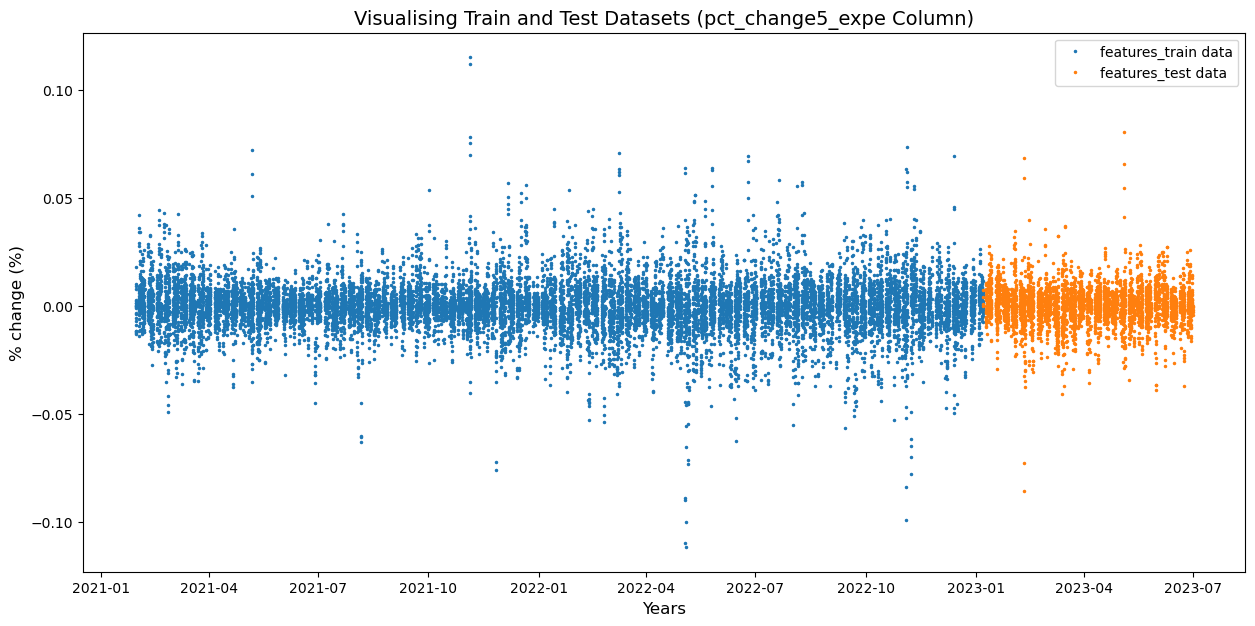

In [12]:
plt.figure(figsize = (15, 7))
plt.plot(features_train['pct_change5_expe'], linestyle = 'None', marker = '.', markersize = 3.0, label = 'features_train data')
plt.plot(features_test['pct_change5_expe'], linestyle = 'None', marker = '.', markersize = 3.0, label = 'features_test data')
plt.title("Visualising Train and Test Datasets (pct_change5_expe Column)", fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('% change (%)', fontsize=12)
plt.legend()
plt.show()

Once again, we save the data frames as CSV files in the files directory. 

## 4) ML Classification Model Training and Forecasting

We will now use the `features_train` and `target_train` dataframes to train a machine learning model.

A random forest classifier is used. A random forest classifier combines multiple decision trees to make accurate predictions. Each decision tree is trained on a different subset of the data and features, resulting in a diverse set of trees. When making predictions, the random forest combines the outputs of all the trees to reach a final prediction. This ensemble approach helps to reduce overfitting and increase the model's ability to generalize to unseen data. Random forest classifiears are suitable for stock prediction because they can handle large and complex datasets, capture intricate relationships between variables, and provide insights into the relative importance of different factors influencing stock market trends.

In [13]:
rf_model = RandomForestClassifier(n_estimators = 5, max_features = 8, max_depth = 5, random_state = 4, min_samples_split=2, min_samples_leaf=1)
rf_model.fit(features_train, target_train['signal'])
target_pred = rf_model.predict(features_test)

## 5) Evaluation
The evaluation is done by creating a confustion matrix and by considering three metrics: the accuracy, recall and f1-score.

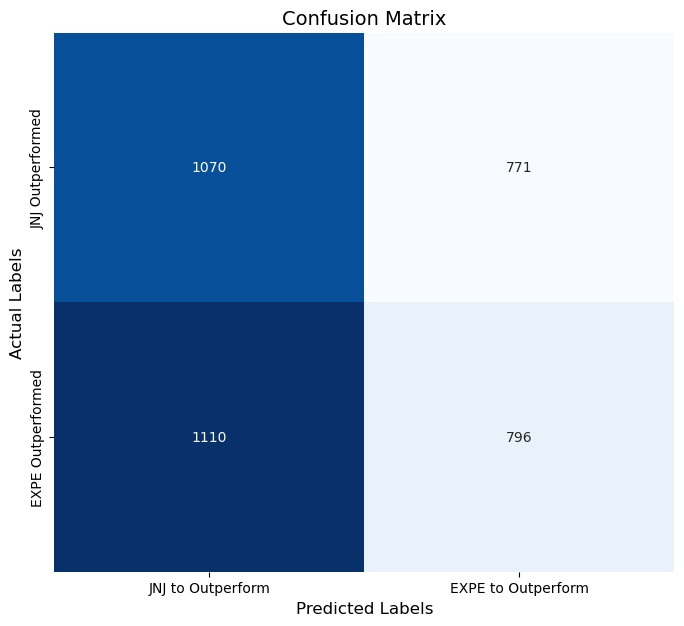

In [14]:
confusion_matrix_data = confusion_matrix(target_test['signal'].values, target_pred)
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(confusion_matrix_data, fmt="d", cmap='Blues', cbar=False, annot=True, ax=ax)
ax.set_xlabel('Predicted Labels', fontsize=12)
ax.set_ylabel('Actual Labels', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)
ax.xaxis.set_ticklabels(['JNJ to Outperform', 'EXPE to Outperform'])
ax.yaxis.set_ticklabels(['JNJ Outperformed', 'EXPE Outperformed'])
plt.show()

We now look at evaluation metrics which are provided by the `classification_report` function from the `scikit-learn` library. 

In [15]:
crd = classification_report(target_test, target_pred)
print(crd)

              precision    recall  f1-score   support

           0       0.49      0.58      0.53      1841
           1       0.51      0.42      0.46      1906

    accuracy                           0.50      3747
   macro avg       0.50      0.50      0.50      3747
weighted avg       0.50      0.50      0.49      3747



While accuracy, recall, and F1-score are useful evaluation metrics in stock predicting ML algorithms, they may not fully capture the algorithm's true effectiveness. Financial markets' unpredictability and the metrics' limitations in considering profitability and misclassifications underscore the need for backtesting. Backtesting, which simulates the algorithm's performance on historical data, is crucial in assessing real-world effectiveness, profitability, and validation. Backtesting will be done in the following section.

## 6) Backtesting
To backtest the strategy, we will first create a new column that contains the returns for each 15min interval. This is done by either subtracting Expedia Group's returns from Johnson and Johnson or vice versa depending on the predicted signal. The cumulative returns are then calculated by taking the cumulative product of these returns. 

In [16]:
results = data[['future_returns_expe', 'future_returns_jnj']].copy()
target_test['prediction'] = target_pred
strategy_data = pd.merge(target_test, results, on = 'Date', how = 'left')
strategy_data['returns'] = np.where(strategy_data['prediction'] == 1, strategy_data['future_returns_expe']-strategy_data['future_returns_jnj'], strategy_data['future_returns_jnj'] - strategy_data['future_returns_expe'])
strategy_data['cumulative_returns'] = (1 + strategy_data['returns']).cumprod()
strategy_data.head()

,signal,prediction,future_returns_expe,future_returns_jnj,returns,cumulative_returns
Date,,,,,,
2023-01-06 20:15:00+00:00,0,0,0.001059,0.001799,0.000740,1.000740
2023-01-06 20:30:00+00:00,0,0,-0.004549,-0.000854,0.003695,1.004438
2023-01-06 20:45:00+00:00,0,1,0.000106,0.000111,-0.000005,1.004434
2023-01-06 21:00:00+00:00,0,1,-0.001169,0.000000,-0.001169,1.003259
2023-01-09 14:15:00+00:00,1,0,0.006356,0.003693,-0.002663,1.000588


The cumulative returns of the strategy are then plotted below. 

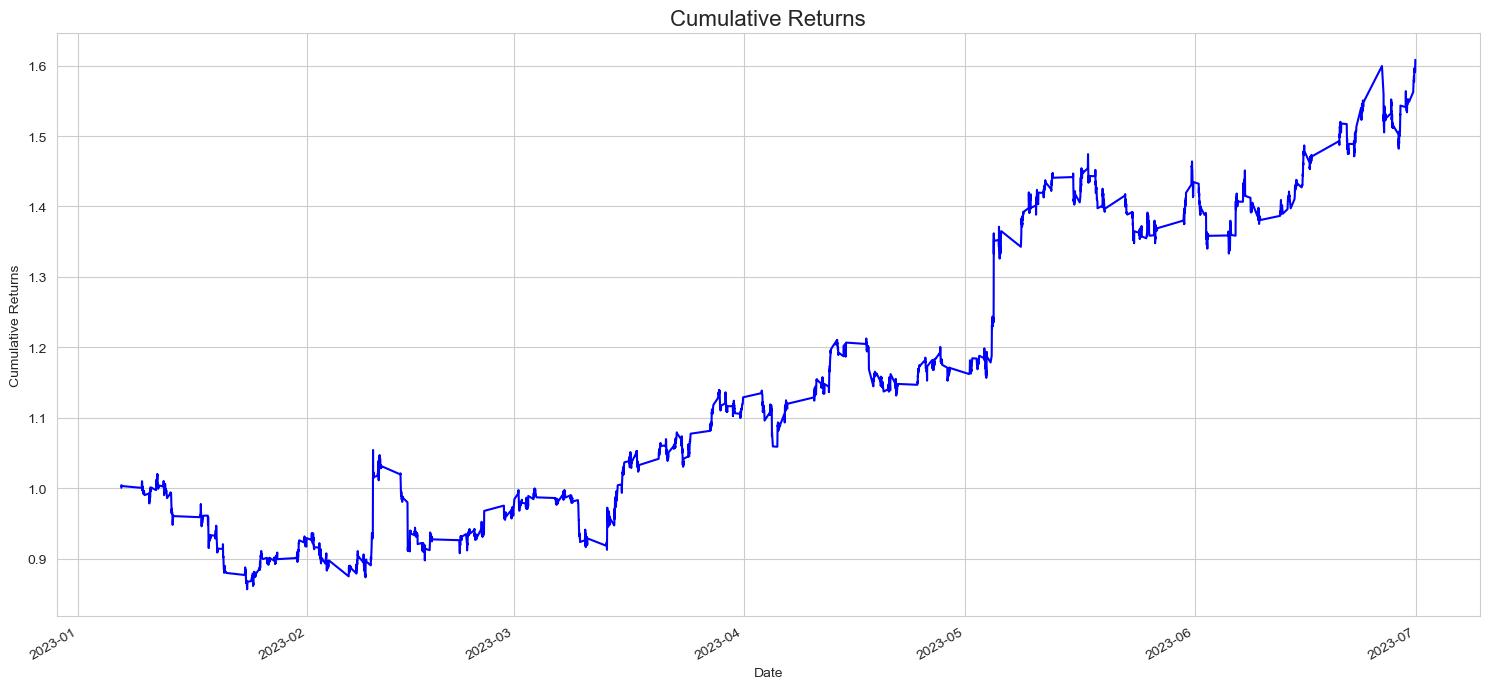

The cumulative return is 60.82%.


In [17]:
# Set the style
sns.set_style("whitegrid")
# Plotting the cumulative returns
plt.figure(figsize=(15, 7))
strategy_data['cumulative_returns'].plot(color='blue')
plt.title('Cumulative Returns', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Calculate and print the cumulative return
cumulative_returns = (strategy_data['cumulative_returns'][-1] - 1) * 100
print("The cumulative return is {0:.2f}%.".format(cumulative_returns))


In approximately 6 months, the strategy yielded 60.82%. We will now analyse the returns generated by the strategy and the associated risk using different performance metrics, the first being annualised returns.

In [18]:
annualised_return = ((strategy_data['cumulative_returns'][-1]) **(day*252/strategy_data.shape[0]) - 1) * 100
print("The annualised return is {0:.2f}%.".format(annualised_return))

The annualised return is 129.50%.


We proceed by calculating the annualised volatility, which means that for approximately 68% of the year the price would differ by less than the annualised volatility compared to the previous time.

In [19]:
# Calculate the annualised volatility
annualised_volatility = strategy_data['returns'].std()*np.sqrt(252*day) * 100
print("The annualised volatility is {0:.2f}%.".format(annualised_volatility))

The annualised volatility is 38.72%.


The next step is to visualise the maximum drawdown, in order to see how much losses we can expect from the algorithm.  

The maximum drawdown is -16.02%.


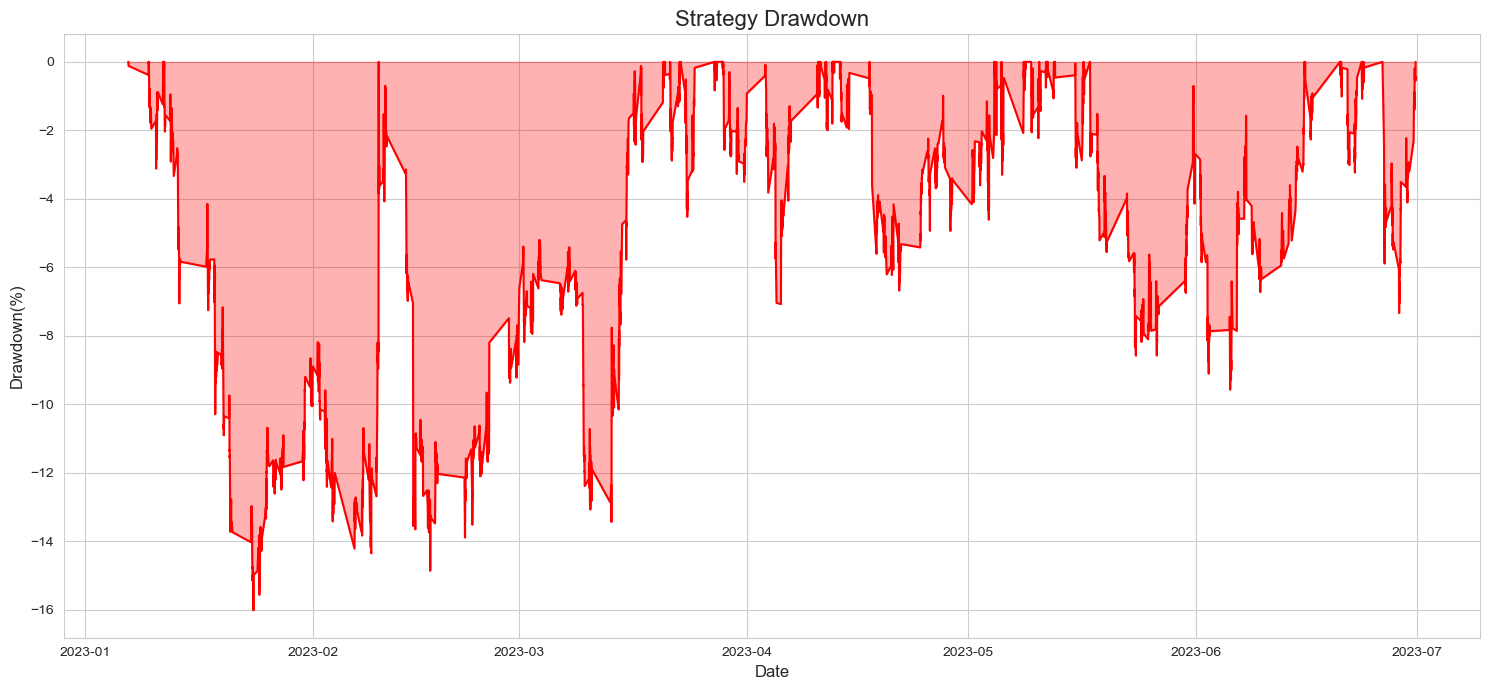

In [20]:
# Calculate the running maximum
running_max = np.maximum.accumulate(strategy_data['cumulative_returns'].dropna())
running_max[running_max < 1] = 1
drawdown = ((strategy_data['cumulative_returns']) / running_max - 1) * 100
max_dd = drawdown.min()
print("The maximum drawdown is {0:.2f}%.".format(max_dd))

# Plotting the drawdown
fig = plt.figure(figsize=(15, 7))
plt.plot(drawdown, color='red')
plt.fill_between(drawdown.index, drawdown.values, color='red', alpha=0.3)
plt.title('Strategy Drawdown', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Drawdown(%)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

The final metric that is calculated is the sharpe ratio.

In [21]:
sharpe_ratio = round(strategy_data['returns'].mean() / strategy_data['returns'].std() * np.sqrt(252*day), 2)
print("The Sharpe ratio is {0:.2f}.".format(sharpe_ratio))

The Sharpe ratio is 2.34.
